# Starbucks Promotion Analysis Vol.2/2
 
## Direction of this project


In this project, I will create a predictive model to predict whether a customer would complete a coupon or not **when they first view it**. 

This model is made by users who don't have any null value in their attributes, and also users who viewed BOGO or discount coupons at least 3 times.


(Even though a customer does not view or display the coupon in the shop, the coupon can be automatically completed once he spends the amount needed.)

This model uses mainly 4 kinds of features for prediction.

1. Coupon's info
2. Customer's attribute
3. Customer's behavior to **past coupons**
4. Situation when the customer viewed **this coupon**


## Table of contents
* Notebook 1 (190315StarbucksPromotionAnalysis.ipynb)

```
1. Load in files
2. Clean the data
3. Univariate Exploration
4. Multivariate Exploration
5. Make a dataframe whose each row represents each coupon sent in this observation period
6. Basic Feature Engineering
```

* Notebook 2 (190403StarbucksPromotionAnalysis.ipynb)   

```
1. Load in files
2. Feature engineering 1 (make columns representing the distribution of customer's past viewing time for coupons)
3. Feature engineering 2 (make a column representing the customer's past total completion rate)
4. Feature engineering 3 (make columns representing the customer's past total completion rate in 4 situation)
5. Create a model
6. Interpretation of the model
```

# 1. Load in files

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
% matplotlib inline

# details of 10 coupons
portfolio = pd.read_csv('data/portfolio_clean.csv', )
# each customer's attribute
profile = pd.read_csv('data/profile_clean.csv')
# all the action of all customers
transcript = pd.read_csv('data/transcript_clean.csv')
# dataframe whose each row reperesents each coupon sent
interaction = pd.read_csv("data/interaction.csv")
# extracted dataframe of "interaction". offers which are firstly viewed
offer_viewed = pd.read_csv("data/firstly_viewed_offers.csv")

pd.options.display.max_rows = 100
pd.set_option("display.max_columns", 500)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"['email', 'mobile', 'social']",10,7,bogo_7days$10,bogo,10
1,"['web', 'email', 'mobile', 'social']",10,5,bogo_5days$10,bogo,10
2,"['web', 'email', 'mobile']",0,4,info_4days,informational,0
3,"['web', 'email', 'mobile']",5,7,bogo_7days$5,bogo,5
4,"['web', 'email']",20,10,disc_10days$20-$5,discount,5


In [3]:
profile.head()

,age,became_member_on,id,income,gender_F,gender_M,gender_O
0,NaN,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1.0,0.0,0.0
2,NaN,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN,NaN,NaN
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1.0,0.0,0.0
4,NaN,2017-08-04,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,NaN


In [4]:
transcript.head()

,event,person,time,transaction,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,bogo_7days$5
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,disc_10days$20-$5
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,disc_7days$10-$2
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,disc_10days$10-$2
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,bogo_5days$10


In [35]:
print(interaction.shape)
interaction.head()

(48326, 27)


,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,1.0,0.0,0.0,2017,0.500000,-8.660254e-01,0.968077,-0.250653,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,6.0,0.0,132.0,19.89
1,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,-5.000000e-01,0.724793,0.688967,-0.433884,-0.900969,0,1,20,10,5,1,0,0,1,0,6.0,0.0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,68.0,70000.0,0.0,1.0,0.0,2018,0.866025,-5.000000e-01,-0.848644,0.528964,0.433884,-0.900969,0,1,10,7,2,1,1,0,1,0,18.0,0.0,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,NaN,NaN,NaN,NaN,2017,-1.000000,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,0,1,10,10,2,1,1,1,1,0,12.0,0.0,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,5.000000e-01,0.394356,0.918958,0.000000,1.000000,1,0,10,5,10,1,1,1,1,0,84.0,0.0,NaN,NaN


In [6]:
print(offer_viewed.shape)
offer_viewed.head()

(32007, 27)


,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,1.0,0.0,0.0,2017,0.500000,-8.660254e-01,0.968077,-0.250653,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,6.0,0.0,132.0,19.89
1,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,-5.000000e-01,0.724793,0.688967,-0.433884,-0.900969,0,1,20,10,5,1,0,0,1,0,6.0,0.0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,68.0,70000.0,0.0,1.0,0.0,2018,0.866025,-5.000000e-01,-0.848644,0.528964,0.433884,-0.900969,0,1,10,7,2,1,1,0,1,0,18.0,0.0,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,NaN,NaN,NaN,NaN,2017,-1.000000,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,0,1,10,10,2,1,1,1,1,0,12.0,0.0,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,5.000000e-01,0.394356,0.918958,0.000000,1.000000,1,0,10,5,10,1,1,1,1,0,84.0,0.0,NaN,NaN


In [36]:
# remove offers whose receivers has null values in his attributes

offer_viewed_no_null = offer_viewed[offer_viewed.isnull().iloc[:,:10].sum(axis = 1) == 0]

In [37]:
print(offer_viewed_no_null.shape)
offer_viewed_no_null.groupby("person")["offer_bogo"].count().value_counts().sort_index()

(26971, 27)


1    4328
2    5032
3    2844
4     873
5     111
Name: offer_bogo, dtype: int64

#### I will use customers [who got more than or equal to 3 discount/BOGO coupons] and [no null values in the customer info].
This means that I can use 3828 rows for creating a predictive model.
Again, I will make a model which predicts whether [a custmer who had offers more than 2 offers] would see the next offer or not.

In [42]:
# customers who got more than or equal to 3 discount/BOGO coupons
customers_for_model = offer_viewed_no_null.groupby("person")["offer_bogo"].count().index[offer_viewed_no_null.groupby("person")["offer_bogo"].count() >= 3]

# extract rows who has null values in the customers' info
offer_viewed_no_null_3or_more = offer_viewed_no_null[offer_viewed_no_null.person.isin(customers_for_model)]
offer_viewed_no_null_3or_more.shape

(12579, 27)

#### Extract rows which represents the last offers sent to each of customers

In [41]:
# The last time when the last offer was sent to each of customers
offer_person_time = offer_viewed_no_null_3or_more.groupby("person").max()["t_received"]
print(offer_person_time.shape)
offer_person_time.head()

(3828,)


person
0011e0d4e6b944f998e987f904e8c1e5    504
0020ccbbb6d84e358d3414a3ff76cffd    504
004c5799adbf42868b9cff0396190900    504
00857b24b13f4fe0ad17b605f00357f5    504
008d7088107b468893889da0ede0df5c    504
Name: t_received, dtype: int64

In [12]:
# Boolean mask which indicates whether the row is the last offer for the person
last_mask = (offer_viewed_no_null_3or_more["person"] + offer_viewed_no_null_3or_more["t_received"].astype(str)).isin(
        offer_person_time.index + offer_person_time.astype(str))

offer_viewed_no_null_3or_more_last = offer_viewed_no_null_3or_more[last_mask]

In [40]:
print(offer_viewed_no_null_3or_more_last.shape)
offer_viewed_no_null_3or_more_last.head()

(3828, 27)


,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
14130,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57
14136,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20
14152,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31
14159,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00
14182,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92


# 2. Feature Engineering1 : integrate the distribution of viewing time of the coupon


The distribution of time which each customer spent till he viewed offers can be the great variable which represents customer's behavior pattern. Note that the distribution should exclude view_times when he completed the coupon before that. (It can be imagined that the customer viewed a coupon because he noticed it because of the discount.)

For this section, the type of coupons (BOGO or discount or info) doesn't matter.

In [14]:
# extract necessary columns
t_viewed = interaction.copy()[["person", "t_received", "t_viewed"]]

In [16]:
# replace t = nan(never viewed) with 1000(arbitrary long hour : interpreted as it takes 1000 hours till he views) 
t_viewed.t_viewed = t_viewed.t_viewed.replace(np.nan,1000)

# mask of boolean which represents whether each offer was viewed until t = 120 hours
mask_over_120hour = t_viewed.t_viewed.astype(int) // 120 > 0

In [224]:
# now the offers which are not viewed until t = 120 hours are replaced by 1000 tentatively. 
t_viewed.loc[mask_over_120hour, "t_viewed"] = 777

t_viewed.head(10)

,person,t_received,t_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,6.0
1,a03223e636434f42ac4c3df47e8bac43,0,6.0
2,e2127556f4f64592b11af22de27a7932,0,18.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,12.0
4,68617ca6246f4fbc85e91a2a49552598,0,84.0
5,389bc3fa690240e798340f5a15918d5c,0,0.0
6,c4863c7985cf408faee930f111475da3,0,24.0
7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0
8,31dda685af34476cad5bc968bdb01c53,0,777.0
9,744d603ef08c4f33af5a61c8c7628d1c,0,48.0


In [18]:
t_viewed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 3 columns):
person        48326 non-null object
t_received    48326 non-null int64
t_viewed      48326 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [50]:
# Create a empty dataframe. Each row represents each customer.

index = pd.Series(t_viewed.t_viewed.unique()).sort_values()
df = pd.DataFrame(columns=index)
df["person"] = offer_viewed_no_null_3or_more_last.person
df = df.replace(np.nan, 0)
df.head()

,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,777.0,person
14130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31dda685af34476cad5bc968bdb01c53
14136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1e9420836d554513ab90eba98552d0a9
14152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99e9a1916821461ebd5d5048dc2dff7d
14159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9aba5058cb4f483da896335a1479a944
14182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,127cd9d95e6247e5b92bff64d6205a94


In [51]:
# fill 1 in "df" according to when the customer of each row viewed coupons in the past. 
t = time.time()

person_index = []

# for each of the row which represents the last offer to each person who has got >= 3 offers...
for i, (each_person, each_time) in enumerate(zip(offer_viewed_no_null_3or_more_last.person, offer_viewed_no_null_3or_more_last.t_received)):
    
    # offers sent to that person BEFORE that last offer
    offers_before =  t_viewed[(t_viewed.person == each_person) & (t_viewed.t_received < each_time)]
    
    for t in offers_before.t_viewed:
        temp_row = df.iloc[i].copy()
        temp_row.loc[t] += 1
        df.iloc[i] = temp_row

time.time() - t

1555873083.711358

In [54]:
# "df" represents the time distribution each customer spent before he viewed given coupons in the past.
print(df.shape)
df.head()

(3828, 22)


,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,777.0,person
14130,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,31dda685af34476cad5bc968bdb01c53
14136,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1e9420836d554513ab90eba98552d0a9
14152,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99e9a1916821461ebd5d5048dc2dff7d
14159,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9aba5058cb4f483da896335a1479a944
14182,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,127cd9d95e6247e5b92bff64d6205a94


In [64]:
# Convert df into Cumulative Distribution of number of viewed coupons
df2 = df.replace(np.nan, 0)
df2.iloc[:,:-1] = df2.iloc[:,:-1].cumsum(axis=1)
df2 = df2.rename(columns = {777:"denom_viewed"})
df2.head()

,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,person
14130,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,31dda685af34476cad5bc968bdb01c53
14136,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,1e9420836d554513ab90eba98552d0a9
14152,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,99e9a1916821461ebd5d5048dc2dff7d
14159,0,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,9aba5058cb4f483da896335a1479a944
14182,0,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,127cd9d95e6247e5b92bff64d6205a94


In [65]:
# Convert df into Cumulative Distribution of probability that coupon is viewed at each time
for column_name in df2.columns[:-2]:
        df2[column_name] = df2[column_name].astype(float) / df2.denom_viewed
        
print(df2.shape)
df2.sample(5)

(3828, 22)


,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,person
23808,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,2,8c4043ca07cf48c6a71fe5155768237a
19541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2,24a3df24be334727a9b6a704a1b536e6
21051,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2,23be2bae33d54da884c7ff0230fc241f
30216,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2,68213b08d99a4ae1b0dcb72aebd9aa35
28199,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,3,e46283405b094b62806e05f24c5f0304


In [66]:
# merge this into "offer_viewed_no_null_3or_more_last"
merged_df = offer_viewed_no_null_3or_more_last.merge(df2)
print(merged_df.shape)
merged_df.head()

(3828, 48)


,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2


# 3. Feature Engineering 2 : Past total completion rate (0~1) of offers sent to him

This is the most simple and helpful feature which represents the customer's behavior pattern. This represents the completion rate of the coupons sent to him [no matter which coupon it was] and [no matter how many hours were left till the deadline of the coupon when he opened] etc...

In section 4, completion rate depending on the situation when he viewed that coupon would also be integrated as new features.  

In [79]:
# dictionary how many offers(BOGO/discount) were sent to the customer
dict_person_to_past_offer_num = {}
# dictionary the probability that offers(BOGO/discount) sent to the customer was completed
dict_person_to_past_completion_rate = {}

for each_person, each_time in zip(merged_df.person, merged_df.t_received):
    prev_trans_df = offer_viewed_no_null_3or_more[(offer_viewed_no_null_3or_more.person == each_person) & (offer_viewed_no_null_3or_more.t_received < each_time)]
    dict_person_to_past_offer_num[each_person] = prev_trans_df.shape[0]
    dict_person_to_past_completion_rate[each_person] = prev_trans_df.t_completed.count() / prev_trans_df.shape[0]

In [80]:
# add the columns using dictionaries made up above.
merged_df["past_offers_num"] = merged_df["person"].apply(lambda x : dict_person_to_past_offer_num[x])
merged_df["past_completion_rate"] = merged_df["person"].apply(lambda x : dict_person_to_past_completion_rate[x])

In [84]:
print(merged_df.shape)
merged_df.head()

(3828, 50)


,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5


In [90]:
# Confirm that newly added 2 columns stores possible values
print(merged_df.past_completion_rate.unique())
print(merged_df.past_offers_num.unique())

[0.5        1.         0.         0.33333333 0.66666667 0.75
 0.25      ]
[2 3 4]


# 4. Feature Engineering 3 : Past completion rate (0~1) of offers sent to him in each of  4 situations when he viewed the coupon

The probability whether a coupon would be accomplished or not relies on the situation when he viewed it to some extent. In other words, even for the same coupon, 

Situation 1 : the duration left for the coupon is 12 hours and he has to spend \\$10 more to achieve it.  
Situation 2 : the duration left for the coupon is 5 days and he has to spend \\$1 more to achieve it.  

In this case, it is easily imagined that situation 2 would motivates customer more.   
That being said, I divided the past situations when he viewed coupons into 4 as written below.
 
 

>When the customer viewed the coupon,
>
> * The valid time left was so short (less than or equal to 128 hours)
> * The valid time left was so long (more than 128 hours)  
> ✖️
> * He had to spent a little more money till coupon completion. (less than \$10)
> * He had to spent a lot more money till coupon completion. (more than or equal to \$10)

I calculated the probability(0~1) that a person completed an offer in each of situation in the past and added these 4 new variables.

It is ideal that the reward amount would be also used and the past situations would be divided into 8. However, the dataset I got here is limited that I did not do it.

In [98]:
# list of customers who received 3 or more offers and not have null attributes
customers_3_or_more_offers = offer_viewed_no_null_3or_more.person.unique()
print(len(customers_3_or_more_offers))
print(customers_3_or_more_offers[:5])

3828
['389bc3fa690240e798340f5a15918d5c' '31dda685af34476cad5bc968bdb01c53'
 'f806632c011441378d4646567f357a21' 'd058f73bf8674a26a95227db098147b1'
 '1e9420836d554513ab90eba98552d0a9']


In [100]:
# extract the transactions which are the last offer given to each person.
person_to_last_offer_time = offer_viewed_no_null_3or_more.groupby("person").t_received.max()
person_to_last_offer_time.head()

person
0011e0d4e6b944f998e987f904e8c1e5    504
0020ccbbb6d84e358d3414a3ff76cffd    504
004c5799adbf42868b9cff0396190900    504
00857b24b13f4fe0ad17b605f00357f5    504
008d7088107b468893889da0ede0df5c    504
Name: t_received, dtype: int64

In [101]:
# Create dictioary from above. (key = "person id" > value = "time when the last offer was sent to him")
dict_person_to_last_offer_t = {}
for each_person, each_t in zip(person_to_last_offer_time.index, person_to_last_offer_time):
    dict_person_to_last_offer_t[each_person] = each_t

In [111]:
# dataframe whose each row repesents each offer.
# The offers in this df is limited to
#       offers sent to the person who got more than 2 offers
#       offers sent to the person BEFORE THE LAST ONE


offer_viewed_no_null_3or_not_last = offer_viewed_no_null_3or_more\
        [offer_viewed_no_null_3or_more.t_received <\
            offer_viewed_no_null_3or_more.person.apply(lambda x : dict_person_to_last_offer_t[x])]

In [112]:
offer_viewed_no_null_3or_more.shape, offer_viewed_no_null_3or_not_last.shape

((12579, 27), (8751, 27))

### Check the situation when the offer were viewed in the past.

Mainly in 2 points of view.
1. How much money did a user had to use to reach the difficulty
2. How much hours left till the offer becomes invalid

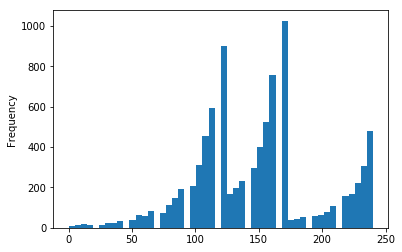

In [115]:
# distribution of resting time when a customer viewed an offer
(offer_viewed_no_null_3or_not_last.duration * 24 - offer_viewed_no_null_3or_not_last.t_viewed).plot("hist", bins = 50);

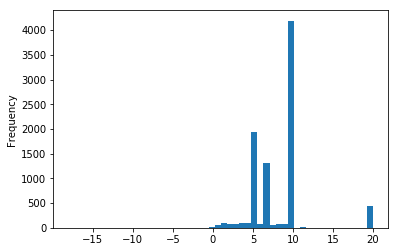

In [116]:
# distribution of resting amount to be used to achieve the offer when a customer viewed an offer
(offer_viewed_no_null_3or_not_last.difficulty - offer_viewed_no_null_3or_not_last.amt_till_viewed).plot("hist", bins = 50);

### I found that the resting amount to be used to achieve the offer takes negative value!!!

I check the rows which do.

In [117]:
# the rows of an offer whose resting amount to be used to achieve the offer takes negative value.
offer_viewed_no_null_3or_not_last[(offer_viewed_no_null_3or_not_last.difficulty - offer_viewed_no_null_3or_not_last.amt_till_viewed)<0]

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
1289,c58726d95ba8447ba01036e9d50da94c,64.0,52000.0,0.0,1.0,0.0,2016,1.000000e+00,6.123234e-17,-3.943559e-01,0.918958,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,138.0,7.04,NaN,NaN
1436,ec24a28bab9a4548baa8a3f34800f8e1,77.0,70000.0,1.0,0.0,0.0,2018,1.224647e-16,-1.000000e+00,-8.978045e-01,-0.440394,0.433884,-0.900969,1,0,10,5,10,1,1,1,1,0,66.0,10.34,NaN,NaN
3623,26873f30a4b740e1b1831fc5e76d2fd3,52.0,32000.0,1.0,0.0,0.0,2014,5.000000e-01,-8.660254e-01,-7.907757e-01,-0.612106,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,138.0,11.75,NaN,NaN
5105,56a24501a23f4d34b70d88ab867b65e2,43.0,36000.0,1.0,0.0,0.0,2016,-5.000000e-01,8.660254e-01,-9.680771e-01,-0.250653,0.781831,0.623490,1,0,10,5,10,1,1,1,1,0,102.0,13.67,NaN,NaN
8565,e63bbd64cf5e43baa4dd9ef77c99f050,58.0,39000.0,0.0,1.0,0.0,2014,8.660254e-01,-5.000000e-01,-4.853020e-01,-0.874347,-0.433884,-0.900969,1,0,5,5,5,1,1,1,1,168,72.0,8.37,NaN,NaN
9391,fb89e4ae9fbc4a3d8f701556290ac87c,29.0,55000.0,0.0,1.0,0.0,2017,1.000000e+00,6.123234e-17,-6.513725e-01,-0.758758,-0.781831,0.623490,1,0,5,7,5,1,1,0,1,168,48.0,5.08,90.0,11.02
9415,49295418cdfb40aba2dba760b44a0a08,44.0,34000.0,1.0,0.0,0.0,2017,1.000000e+00,6.123234e-17,8.978045e-01,-0.440394,-0.433884,-0.900969,1,0,10,5,10,1,1,1,1,168,66.0,13.06,NaN,NaN
10252,40ce078d5b2a43d19138a788754520be,61.0,31000.0,0.0,1.0,0.0,2016,5.000000e-01,-8.660254e-01,3.943559e-01,0.918958,0.000000,1.000000,1,0,10,7,10,1,1,1,0,168,18.0,10.12,30.0,25.92
11193,da6918b53fd54371a5ce83b2092fd01c,45.0,55000.0,0.0,1.0,0.0,2017,-8.660254e-01,-5.000000e-01,-2.449294e-16,1.000000,0.433884,-0.900969,1,0,5,5,5,1,1,1,1,168,24.0,6.74,NaN,NaN
11461,e0780fee1ddf45f98fcc65beb58966a1,19.0,51000.0,0.0,1.0,0.0,2016,5.000000e-01,-8.660254e-01,9.987165e-01,-0.050649,-0.781831,0.623490,1,0,5,5,5,1,1,1,1,168,12.0,6.98,78.0,20.69


In [118]:
# Take a closer look at 1 of them.
transcript[transcript.person == "c58726d95ba8447ba01036e9d50da94c"]

,event,person,time,transaction,id
2215,offer received,c58726d95ba8447ba01036e9d50da94c,0,NaN,bogo_7days$5
28148,transaction,c58726d95ba8447ba01036e9d50da94c,42,2.50,NaN
37150,transaction,c58726d95ba8447ba01036e9d50da94c,78,0.84,NaN
48706,offer viewed,c58726d95ba8447ba01036e9d50da94c,138,NaN,bogo_7days$5
48707,transaction,c58726d95ba8447ba01036e9d50da94c,138,3.70,NaN
50595,transaction,c58726d95ba8447ba01036e9d50da94c,150,3.96,NaN
52411,transaction,c58726d95ba8447ba01036e9d50da94c,162,1.34,NaN
55412,offer received,c58726d95ba8447ba01036e9d50da94c,168,NaN,disc_10days$10-$2
85635,offer viewed,c58726d95ba8447ba01036e9d50da94c,216,NaN,disc_10days$10-$2
87438,transaction,c58726d95ba8447ba01036e9d50da94c,222,2.53,NaN


### What I've found is that BOGO difficulty is not for accumulating amount. BOGO has to be achieved at one time.

For example, if a customer has spent $1.5 when he viewed a coupon,

1. For discount, he has to spend \$3.5 more cumulatively.
2. For BOGO, he has to spend \$5 more at a time.

For simplicity, I just take care of the amount.

In [120]:
# How much more money he had to spend when he viewed an offer??
offer_viewed_no_null_3or_not_last["goal_amt_when_viewed"] = offer_viewed_no_null_3or_not_last.difficulty\
                                                                - offer_viewed_no_null_3or_not_last.amt_till_viewed

# but for example of $5 BOGO, he had to spend $5 more even if he had spent &4.9 when he viewed the offer
mask_bogo = (offer_viewed_no_null_3or_not_last.offer_bogo == 1)
offer_viewed_no_null_3or_not_last.loc[mask_bogo,"goal_amt_when_viewed"] = offer_viewed_no_null_3or_not_last.loc[mask_bogo, "difficulty"]

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [121]:
# How many hours left when he viewed the offer
offer_viewed_no_null_3or_not_last["left_hours_when_viewed"] = offer_viewed_no_null_3or_not_last.duration * 24\
                                                                - offer_viewed_no_null_3or_not_last.t_viewed

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


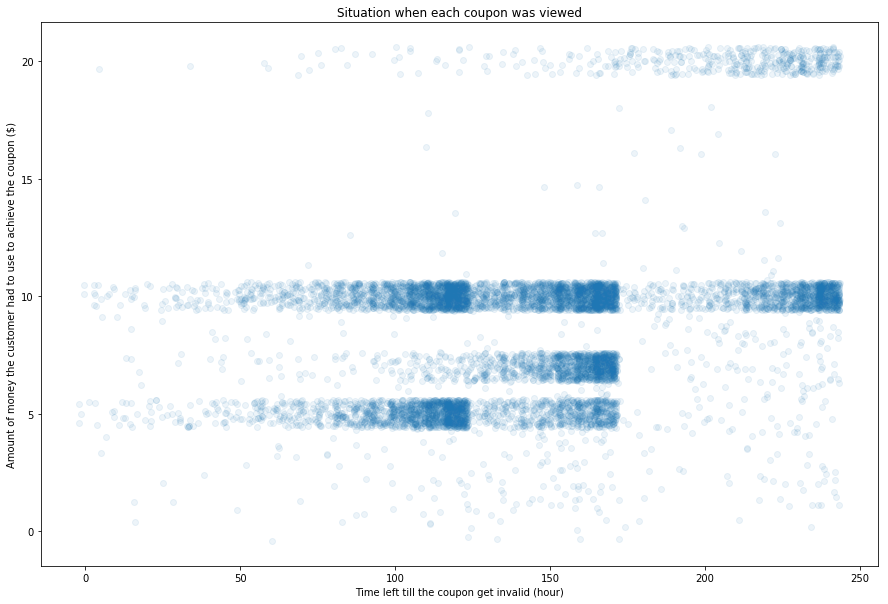

In [132]:
plt.figure(figsize=(15,10))
sns.regplot(data=offer_viewed_no_null_3or_not_last, x="left_hours_when_viewed", y="goal_amt_when_viewed",\
            scatter_kws={"alpha":0.08}, fit_reg=False, x_jitter=3.5, y_jitter=0.6)

plt.title("Situation when each coupon was viewed")
plt.xlabel("Time left till the coupon get invalid (hour)");
plt.ylabel("Amount of money the customer had to use to achieve the coupon ($)");

## I divide these past situations into 4.

 1. (short hours left, a little more purchase needed) > 1738 offers in the past
 2. (short hours left, lot more purchase needed) > 1812 offers in the past
 3. (long hours left, a little more purchase needed) > 2022 offers in the past
 4. (long hours left, lot more purchase needed) > 3179 offers in the past

I set the threshold [at 128 hours for hours left] and [at $10 for amount of money to be spent more].  
These are values to make the number of offers which belong to each of 4 clusters not so biased.

In [193]:
merged_df2 = merged_df.copy()

In [194]:
# 8751 offers should be thought as past offers
offer_viewed_no_null_3or_not_last.shape

(8751, 29)

In [195]:
# offers for which the customer had to spend [less than $10] in [less than or equal to 128 hours]
#                  to achieve when he viewed this
short_little = offer_viewed_no_null_3or_not_last[(offer_viewed_no_null_3or_not_last.left_hours_when_viewed <= 128)
                                                 & (offer_viewed_no_null_3or_not_last.goal_amt_when_viewed < 10)]

# offers for which the customer had to spend [more than $10] in [less than or equal to 128 hours]
#                  to achieve when he viewed this
short_lot = offer_viewed_no_null_3or_not_last[(offer_viewed_no_null_3or_not_last.left_hours_when_viewed <= 128)
                                                 & (offer_viewed_no_null_3or_not_last.goal_amt_when_viewed >= 10)]

# offers for which the customer had to spend [less than $10] in [more than 128 hours]
#                  to achieve when he viewed this
long_little = offer_viewed_no_null_3or_not_last[(offer_viewed_no_null_3or_not_last.left_hours_when_viewed > 128)
                                                 & (offer_viewed_no_null_3or_not_last.goal_amt_when_viewed < 10)]

# offers for which the customer had to spend [more than $10] in [more than 128 hours]
#                  to achieve when he viewed this
long_lot = offer_viewed_no_null_3or_not_last[(offer_viewed_no_null_3or_not_last.left_hours_when_viewed > 128)
                                                 & (offer_viewed_no_null_3or_not_last.goal_amt_when_viewed >= 10)]

In [196]:
# number of offers which belong to each of 4 situations
short_little.shape[0], short_lot.shape[0], long_little.shape[0], long_lot.shape[0]

(1738, 1812, 2022, 3179)

In [197]:
# probability that offer was achieved in each situation (for all customers)
print("short hours left, a little more purchase needed")
print(short_little.t_completed.count()/short_little.shape[0])

print("\nshort hours left, a lot more purchase needed")
print(short_lot.t_completed.count()/short_lot.shape[0])

print("\nlong left, a little more purchase needed")
print(long_little.t_completed.count()/long_little.shape[0])

print("\nlong hours left, a lot more purchase needed")
print(long_lot.t_completed.count()/long_lot.shape[0])

short hours left, a little more purchase needed
0.5143843498273878

short hours left, a lot more purchase needed
0.3923841059602649

long left, a little more purchase needed
0.6988130563798219

long hours left, a lot more purchase needed
0.6162315193457062


#### This makes sense intuitively.

#### Below, I calculate each customer's completion rate of past offers in each situation.

In [198]:
# 1. short time left, a little more purchase needed

# add columns which represents the past completion rate 
#             in the situation of (short hours left, little more purchase needed)

df_temp1 = (short_little.groupby("person")["t_completed"].count() / short_little.groupby("person")["age"].count())
df_temp2 = short_little.groupby("person")["age"].count()

df_short_little_comp_rate = pd.DataFrame(index=df_temp1.index)
df_short_little_comp_rate["short_little_comp_rate"] = df_temp1

df_short_little_count = pd.DataFrame(index=df_temp2.index)
df_short_little_count["short_little_count"] = df_temp2

merged_df2 = merged_df2.merge(df_short_little_comp_rate, how="left", on="person")
merged_df2 = merged_df2.merge(df_short_little_count, how="left", on="person")


merged_df2.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,NaN,NaN
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,NaN,NaN
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,1.0
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,NaN,NaN
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.0,1.0


In [199]:
# 2. short time left, a lot more purchase needed

# add columns which represents the past completion rate 
#             in the situation of (short hours left, a lot more purchase needed)


df_temp1 = (short_lot.groupby("person")["t_completed"].count() / short_lot.groupby("person")["age"].count())
df_temp2 = short_lot.groupby("person")["age"].count()

df_short_lot_comp_rate = pd.DataFrame(index=df_temp1.index)
df_short_lot_comp_rate["short_lot_comp_rate"] = df_temp1

df_short_lot_count = pd.DataFrame(index=df_temp2.index)
df_short_lot_count["short_lot_count"] = df_temp2

merged_df2 = merged_df2.merge(df_short_lot_comp_rate, how="left", on="person")
merged_df2 = merged_df2.merge(df_short_lot_count, how="left", on="person")

merged_df2.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count,short_lot_comp_rate,short_lot_count
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,NaN,NaN,0.0,1.0
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,NaN,NaN,0.5,2.0
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,1.0,NaN,NaN
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,NaN,NaN,1.0,1.0
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.0,1.0,NaN,NaN


In [200]:
# 3. long time left, a little more purchase needed

# add columns which represents the past completion rate 
#             in the situation of (long hours left, a little more purchase needed)

df_temp1 = (long_little.groupby("person")["t_completed"].count() / long_little.groupby("person")["age"].count())
df_temp2 = long_little.groupby("person")["age"].count()

df_long_little_comp_rate = pd.DataFrame(index=df_temp1.index)
df_long_little_comp_rate["long_little_comp_rate"] = df_temp1

df_long_little_count = pd.DataFrame(index=df_temp2.index)
df_long_little_count["long_little_count"] = df_temp2

merged_df2 = merged_df2.merge(df_long_little_comp_rate, how="left", on="person")
merged_df2 = merged_df2.merge(df_long_little_count, how="left", on="person")

merged_df2.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count,short_lot_comp_rate,short_lot_count,long_little_comp_rate,long_little_count
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,NaN,NaN,0.0,1.0,NaN,NaN
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,NaN,NaN,0.5,2.0,NaN,NaN
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,1.0,NaN,NaN,NaN,NaN
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,NaN,NaN,1.0,1.0,NaN,NaN
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.0,1.0,NaN,NaN,NaN,NaN


In [201]:
# 4. long time left, a lot more purchase needed

# add columns which represents the past completion rate 
#             in the situation of (long hours left, a lot more purchase needed)

df_temp1 = long_lot.groupby("person")["t_completed"].count() / long_lot.groupby("person")["age"].count()
df_temp2 = long_lot.groupby("person")["age"].count()

df_long_lot_comp_rate = pd.DataFrame(index=df_temp1.index)
df_long_lot_comp_rate["long_lot_comp_rate"] = df_temp1

df_long_lot_count = pd.DataFrame(index=df_temp2.index)
df_long_lot_count["long_lot_count"] = df_temp2

merged_df2 = merged_df2.merge(df_long_lot_comp_rate, how="left", on="person")
merged_df2 = merged_df2.merge(df_long_lot_count, how="left", on="person")

merged_df2.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count,short_lot_comp_rate,short_lot_count,long_little_comp_rate,long_little_count,long_lot_comp_rate,long_lot_count
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,NaN,NaN,0.0,1.0,NaN,NaN,1.0,1.0
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,NaN,NaN,0.5,2.0,NaN,NaN,NaN,NaN
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0


In [270]:
# replace nan of 0 in 4 columns of "*_*_count"

merged_df2.short_little_count = merged_df2.short_little_count.replace(np.nan, 0)
merged_df2.short_lot_count = merged_df2.short_lot_count.replace(np.nan, 0)
merged_df2.long_little_count = merged_df2.long_little_count.replace(np.nan, 0)
merged_df2.long_lot_count = merged_df2.long_lot_count.replace(np.nan, 0)

In [271]:
merged_df2.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count,short_lot_comp_rate,short_lot_count,long_little_comp_rate,long_little_count,long_lot_comp_rate,long_lot_count
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,NaN,0.0,0.0,1.0,NaN,0.0,1.0,1.0
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,NaN,0.0,0.5,2.0,NaN,0.0,NaN,0.0
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,1.0,NaN,0.0,NaN,0.0,1.0,1.0
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,NaN,0.0,1.0,1.0,NaN,0.0,1.0,1.0
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.0,1.0,NaN,0.0,NaN,0.0,0.0,1.0


In [272]:
assert merged_df2.short_little_count.sum() == short_little.shape[0]
assert merged_df2.short_lot_count.sum() == short_lot.shape[0]
assert merged_df2.long_little_count.sum() == long_little.shape[0]
assert merged_df2.long_lot_count.sum() == long_lot.shape[0]

In [274]:
# How many situations has each of cusomers gone through till the last offer?
(~merged_df2[["short_little_count","short_lot_count","long_little_count","long_lot_count"]].isnull()).sum(axis=1).value_counts().sort_index()

4    3828
dtype: int64

#### This tells us that almost all customers have 1 or more null values in the past completion rate in each of 4 situations. Imputation needed!

#### Possible ways of imputation are

1. replace null with the mean completion rates of that column (that is, the mean rate in each of situation) 
>short_little = 0.5143843498273878   
short_lot = 0.3923841059602649   
long_little = 0.6988130563798219     
long_lot = 0.6162315193457062  

2. replace null with the mean completion rates of that person's "past_completion rate" column
>the first person's null rate should be all 1

3. more complicated way 
>like assuming Nans by combining 1 and 2


Of course imputation 3 can be thought of as the best way, I won't dig deeper into that in this analysis. This is because the data I have here is too little. Getting more data is needed to solve the algorithm.

#### So I will try 1 and 2 when creating a model and decide which to use by comparing the results.

#### Also, the situation when a customer gets the last coupon should be integrated in the dataframe.

In [371]:
# How namy hours are left when a customer viewed the last offer?
merged_df2["t_left_when_viewed"] = merged_df2.duration * 24 - merged_df2.t_viewed
# How namy hours are left when a customer viewed the last offer?
merged_df2["amt_needed_when_viewed"] = merged_df2.difficulty - merged_df2.amt_till_viewed

# For BOGO, it is eaual to the difficulty
mask_bogo = (merged_df2.offer_bogo == 1)
merged_df2.loc[mask_bogo, "amt_needed_when_viewed"] = merged_df2.loc[mask_bogo, "difficulty"]

merged_df2.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count,short_lot_comp_rate,short_lot_count,long_little_comp_rate,long_little_count,long_lot_comp_rate,long_lot_count,t_left_when_viewed,amt_needed_when_viewed
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,NaN,0.0,0.0,1.0,NaN,0.0,1.0,1.0,168.0,7.00
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,NaN,0.0,0.5,2.0,NaN,0.0,NaN,0.0,102.0,10.00
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,1.0,NaN,0.0,NaN,0.0,1.0,1.0,204.0,4.01
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,NaN,0.0,1.0,1.0,NaN,0.0,1.0,1.0,102.0,5.00
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.0,1.0,NaN,0.0,NaN,0.0,0.0,1.0,210.0,6.59


In [372]:
# Save this dataframe in a file
merged_df2.to_csv("data/merged_df2.csv", index=False)

# 5. Create a predictive model


## Model overview 

I used Random Forest Classifier to predict 0(he would complete the coupon) or 1(would not complete). I divided the dataframe into training dataset(3445 rows) and testing dataset (383 rows). I did grid search with cv = 2 to tune hyperparameters.

The reason I chose Random Forest Classifier is that it is easily interpreted after creating a model. It would be done in section 6.


## Imputation

As was written in section 4, there are null values in 4 columns 
* short_little_comp_rate
* short_lot_comp_rate
* long_little_comp_rate 
*long_lot_comp_rate"

I discussed that the way of imputation for these columns should be decided by experimenting both ways. So I tried these 2 ways :   

1. replace null with the mean completion rates of that column (that is, the mean rate in each of situation)  
>replace null with the mean completion rates of that column (that is, the mean rate of each situation)  
>  
>short_little.shape = 0.5143843498273878  
>short_lot.shape = 0.3923841059602649  
>long_little.shape = 0.6988130563798219  
>long_lot.shape = 0.616231519345706  

2. replace null with the mean completion rates of that person's "past_completion rate" column


To tell the result first, **(1) and (2) generated almost the same result**. These Models achieved f1-score = 0.80 in testing dataset after tuning.

In [491]:
merged_df3 = pd.read_csv("data/merged_df2.csv")
merged_df3.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count,short_lot_comp_rate,short_lot_count,long_little_comp_rate,long_little_count,long_lot_comp_rate,long_lot_count,t_left_when_viewed,amt_needed_when_viewed
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,NaN,0.0,0.0,1.0,NaN,0.0,1.0,1.0,168.0,7.00
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,NaN,0.0,0.5,2.0,NaN,0.0,NaN,0.0,102.0,10.00
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,1.0,NaN,0.0,NaN,0.0,1.0,1.0,204.0,4.01
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,NaN,0.0,1.0,1.0,NaN,0.0,1.0,1.0,102.0,5.00
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.0,1.0,NaN,0.0,NaN,0.0,0.0,1.0,210.0,6.59


In [492]:
# Create list of y [0(completed) or 1(not-completed)]

## null in the column "t_completed" means that the offer in the row was not completed.
y = (~merged_df3.t_completed.isnull()).astype(int)

In [506]:
indep_var = ['person', 'age', 'income', 'gender_F', 'gender_M',
       'gender_O', 'became_year', 'became_month_sin', 'became_month_cos',
       'became_day_sin', 'became_day_cos', 'became_dow_sin',
       'became_dow_cos', 'offer_bogo', 'offer_disc', 'difficulty',
       'duration', 'reward', 'email', 'mobile', 'social', 'web',
       't_received', 't_viewed', 'amt_till_viewed',
       '0.0', '6.0', '12.0', '18.0', '24.0', '30.0',
       '36.0', '42.0', '48.0', '54.0', '60.0', '66.0', '72.0', '78.0',
       '84.0', '90.0', '96.0', '102.0', '108.0', '114.0', 'denom_viewed',
       'past_offers_num', 'past_completion_rate',
       'short_little_comp_rate', 'short_little_count',
       'short_lot_comp_rate', 'short_lot_count', 'long_little_comp_rate',
       'long_little_count', 'long_lot_comp_rate', 'long_lot_count',
        "t_left_when_viewed","amt_needed_when_viewed"]

In [545]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pickle

## (1) Imputation1 : replace null with the mean completion rates of that column (that is, the mean completion rate of each situation)

In [495]:
merged_df3.short_little_comp_rate.replace(np.nan, short_little.t_completed.count()/short_little.shape[0], inplace=True)
merged_df3.short_lot_comp_rate.replace(np.nan, short_lot.t_completed.count()/short_lot.shape[0], inplace=True)
merged_df3.long_little_comp_rate.replace(np.nan, long_little.t_completed.count()/long_little.shape[0], inplace=True)
merged_df3.long_lot_comp_rate.replace(np.nan, long_lot.t_completed.count()/long_lot.shape[0], inplace=True)

merged_df3.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count,short_lot_comp_rate,short_lot_count,long_little_comp_rate,long_little_count,long_lot_comp_rate,long_lot_count,t_left_when_viewed,amt_needed_when_viewed
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,0.514384,0.0,0.000000,1.0,0.698813,0.0,1.000000,1.0,168.0,7.00
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,0.514384,0.0,0.500000,2.0,0.698813,0.0,0.616232,0.0,102.0,10.00
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.000000,1.0,0.392384,0.0,0.698813,0.0,1.000000,1.0,204.0,4.01
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,0.514384,0.0,1.000000,1.0,0.698813,0.0,1.000000,1.0,102.0,5.00
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.000000,1.0,0.392384,0.0,0.698813,0.0,0.000000,1.0,210.0,6.59


In [497]:
# split into training data and testing dataset
X_train, X_test, y_train, y_test = train_test_split(merged_df3[indep_var], y, test_size = 0.10, random_state = 0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3445, 58), (383, 58), (3445,), (383,))

### RandomForestClassifier Model

In [520]:
# Using default hyperparameters....
rfc = RandomForestClassifier()
rfc.fit(X=X_train[indep_var2], y=y_train)

y_train_pred = rfc.predict(X_train[indep_var2])
y_test_pred = rfc.predict(X_test[indep_var2])

print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1405
           1       1.00      0.99      0.99      2040

   micro avg       0.99      0.99      0.99      3445
   macro avg       0.99      0.99      0.99      3445
weighted avg       0.99      0.99      0.99      3445

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       158
           1       0.84      0.76      0.80       225

   micro avg       0.78      0.78      0.78       383
   macro avg       0.77      0.78      0.77       383
weighted avg       0.78      0.78      0.78       383



/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [589]:
# Using grid search...

# Number of trees in random forest
n_estimators = [400, 500, 600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,30,40,50,70]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20,100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, pos_label=1)
gd1 = GridSearchCV(RandomForestClassifier(), param_grid = random_grid, cv=2, scoring=f1_scorer, verbose=True,  n_jobs=-1)
gd1.fit(X_train[indep_var2], y_train)


# the results in training dataset / testing dataset
print(metrics.classification_report(y_train, gd1.best_estimator_.predict(X_train[indep_var2])))
print(metrics.classification_report(y_test, gd1.best_estimator_.predict(X_test[indep_var2])))

Fitting 2 folds for each of 1800 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 64.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 75.5min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 81.0min finished


              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1405
           1       0.87      0.92      0.90      2040

   micro avg       0.87      0.87      0.87      3445
   macro avg       0.87      0.86      0.87      3445
weighted avg       0.87      0.87      0.87      3445

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       158
           1       0.81      0.86      0.84       225

   micro avg       0.80      0.80      0.80       383
   macro avg       0.80      0.79      0.79       383
weighted avg       0.80      0.80      0.80       383



In [590]:
gd1.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## (2) Imputatiaon 2 : replace null with the mean completion rates of that person's "past_completion rate" column

In [594]:
merged_df4 = pd.read_csv("data/merged_df2.csv")
merged_df4.head()

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count,short_lot_comp_rate,short_lot_count,long_little_comp_rate,long_little_count,long_lot_comp_rate,long_lot_count,t_left_when_viewed,amt_needed_when_viewed
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,NaN,0.0,0.0,1.0,NaN,0.0,1.0,1.0,168.0,7.00
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,NaN,0.0,0.5,2.0,NaN,0.0,NaN,0.0,102.0,10.00
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,1.0,NaN,0.0,NaN,0.0,1.0,1.0,204.0,4.01
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,NaN,0.0,1.0,1.0,NaN,0.0,1.0,1.0,102.0,5.00
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.0,1.0,NaN,0.0,NaN,0.0,0.0,1.0,210.0,6.59


In [595]:
# fill in null values with the total past completiron rate of the customer.

null_mask = merged_df4.short_little_comp_rate.isnull()
merged_df4.loc[null_mask, "short_little_comp_rate"] = merged_df4.loc[null_mask, "past_completion_rate"]

null_mask = merged_df4.short_lot_comp_rate.isnull()
merged_df4.loc[null_mask, "short_lot_comp_rate"] = merged_df4.loc[null_mask, "past_completion_rate"]

null_mask = merged_df4.long_little_comp_rate.isnull()
merged_df4.loc[null_mask, "long_little_comp_rate"] = merged_df4.loc[null_mask, "past_completion_rate"]

null_mask = merged_df4.long_lot_comp_rate.isnull()
merged_df4.loc[null_mask, "long_lot_comp_rate"] = merged_df4.loc[null_mask, "past_completion_rate"]

In [596]:
merged_df4.head(5)

,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed,0.0,6.0,12.0,18.0,24.0,30.0,36.0,42.0,48.0,54.0,60.0,66.0,72.0,78.0,84.0,90.0,96.0,102.0,108.0,114.0,denom_viewed,past_offers_num,past_completion_rate,short_little_comp_rate,short_little_count,short_lot_comp_rate,short_lot_count,long_little_comp_rate,long_little_count,long_lot_comp_rate,long_lot_count,t_left_when_viewed,amt_needed_when_viewed
0,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,1.0,0.0,0.0,2016,8.660254e-01,5.000000e-01,0.790776,-0.612106,0.433884,-0.900969,0,1,7,7,3,1,1,1,1,336,0.0,0.00,48.0,12.57,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2,2,0.5,0.5,0.0,0.0,1.0,0.5,0.0,1.0,1.0,168.0,7.00
1,1e9420836d554513ab90eba98552d0a9,22.0,70000.0,0.0,1.0,0.0,2017,-1.000000e+00,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,1,0,10,5,10,1,1,1,1,336,18.0,0.00,78.0,30.20,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,2,2,0.5,0.5,0.0,0.5,2.0,0.5,0.0,0.5,0.0,102.0,10.00
2,99e9a1916821461ebd5d5048dc2dff7d,58.0,85000.0,1.0,0.0,0.0,2018,5.000000e-01,8.660254e-01,-0.937752,0.347305,0.433884,-0.900969,0,1,20,10,5,1,0,0,1,336,36.0,15.99,72.0,44.31,0.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,204.0,4.01
3,9aba5058cb4f483da896335a1479a944,65.0,119000.0,1.0,0.0,0.0,2017,-1.000000e+00,-1.836970e-16,0.968077,-0.250653,-0.974928,-0.222521,1,0,5,5,5,1,1,1,1,336,18.0,0.00,42.0,29.00,0.0,0.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,102.0,5.00
4,127cd9d95e6247e5b92bff64d6205a94,46.0,60000.0,0.0,1.0,0.0,2014,-2.449294e-16,1.000000e+00,0.299363,-0.954139,-0.781831,0.623490,0,1,10,10,2,1,1,1,1,336,30.0,3.41,48.0,15.92,0.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,2,0.5,1.0,1.0,0.5,0.0,0.5,0.0,0.0,1.0,210.0,6.59


In [597]:
# split into training data and testing dataset
X_train, X_test, y_train, y_test = train_test_split(merged_df4[indep_var], y, test_size = 0.1, random_state = 0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3445, 58), (383, 58), (3445,), (383,))

### RandomForestClassifier Model

In [598]:
# Using default hyperparameters....
rfc = RandomForestClassifier()
rfc.fit(X=X_train[indep_var2], y=y_train)

y_train_pred = rfc.predict(X_train[indep_var2])
y_test_pred = rfc.predict(X_test[indep_var2])

print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1405
           1       0.99      0.99      0.99      2040

   micro avg       0.99      0.99      0.99      3445
   macro avg       0.99      0.99      0.99      3445
weighted avg       0.99      0.99      0.99      3445

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       158
           1       0.79      0.81      0.80       225

   micro avg       0.77      0.77      0.77       383
   macro avg       0.76      0.75      0.76       383
weighted avg       0.76      0.77      0.76       383



/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [599]:
# Using grid search...

# Number of trees in random forest
n_estimators = [400, 500, 600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,30,40,50,70]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20,100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


f1_scorer = make_scorer(f1_score, pos_label=1)
gd2 = GridSearchCV(RandomForestClassifier(), param_grid = random_grid, cv=2, scoring=f1_scorer, verbose=True,  n_jobs=-1)
gd2.fit(X_train[indep_var2], y_train)


# the results in training dataset / testing dataset
print(metrics.classification_report(y_train, gd2.best_estimator_.predict(X_train[indep_var2])))
print(metrics.classification_report(y_test, gd2.best_estimator_.predict(X_test[indep_var2])))

Fitting 2 folds for each of 1800 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 46.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 51.3min finished


              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1405
           1       0.87      0.91      0.89      2040

   micro avg       0.87      0.87      0.87      3445
   macro avg       0.86      0.85      0.86      3445
weighted avg       0.86      0.87      0.86      3445

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       158
           1       0.81      0.87      0.84       225

   micro avg       0.80      0.80      0.80       383
   macro avg       0.80      0.79      0.79       383
weighted avg       0.80      0.80      0.80       383



In [600]:
gd2.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Both of the models scored almost the same f1 score.
I save the first model (1) in a file "model.pkl".

In [601]:
# Save the model "gd1" in a pkl file
with open("data/model.pkl", 'wb') as file:  
    pickle.dump(gd1, file)

# 6. Interpretation of this model

The reason I used Random Forest Classifier is that I can know how each of features is important for the classification. I visualize the importance of features in descending order.

(REFERENCE : http://aiweeklynews.com/archives/50653819.html)

1   past_completion_rate   0.10823659095118901
2   long_lot_comp_rate   0.08595954918332138
3   short_lot_comp_rate   0.08367514878558703
4   long_little_comp_rate   0.07800267360062899
5   short_little_comp_rate   0.07629602818899717
6   income   0.05515854732093211
7   became_year   0.04978646626207604
8   t_left_when_viewed   0.04372529933213142
9   age   0.032500881997055905
10   reward   0.028411643826730427
11   t_viewed   0.02818576091705314
12   became_day_sin   0.025394052309530565
13   became_day_cos   0.020636502997940502
14   offer_disc   0.020362254248339293
15   offer_bogo   0.018011862096028248
16   amt_till_viewed   0.017038079021295557
17   became_month_cos   0.013689292361550042
18   amt_needed_when_viewed   0.01348575010866454
19   became_month_sin   0.012654230593368994
20   became_dow_sin   0.012047240703728845
21   6.0   0.010895234368922743
22   gender_M   0.010756556206782751
23   0.0   0.010064690721758803
24   12.0   0.009964438159063586
25   duration   0.0095

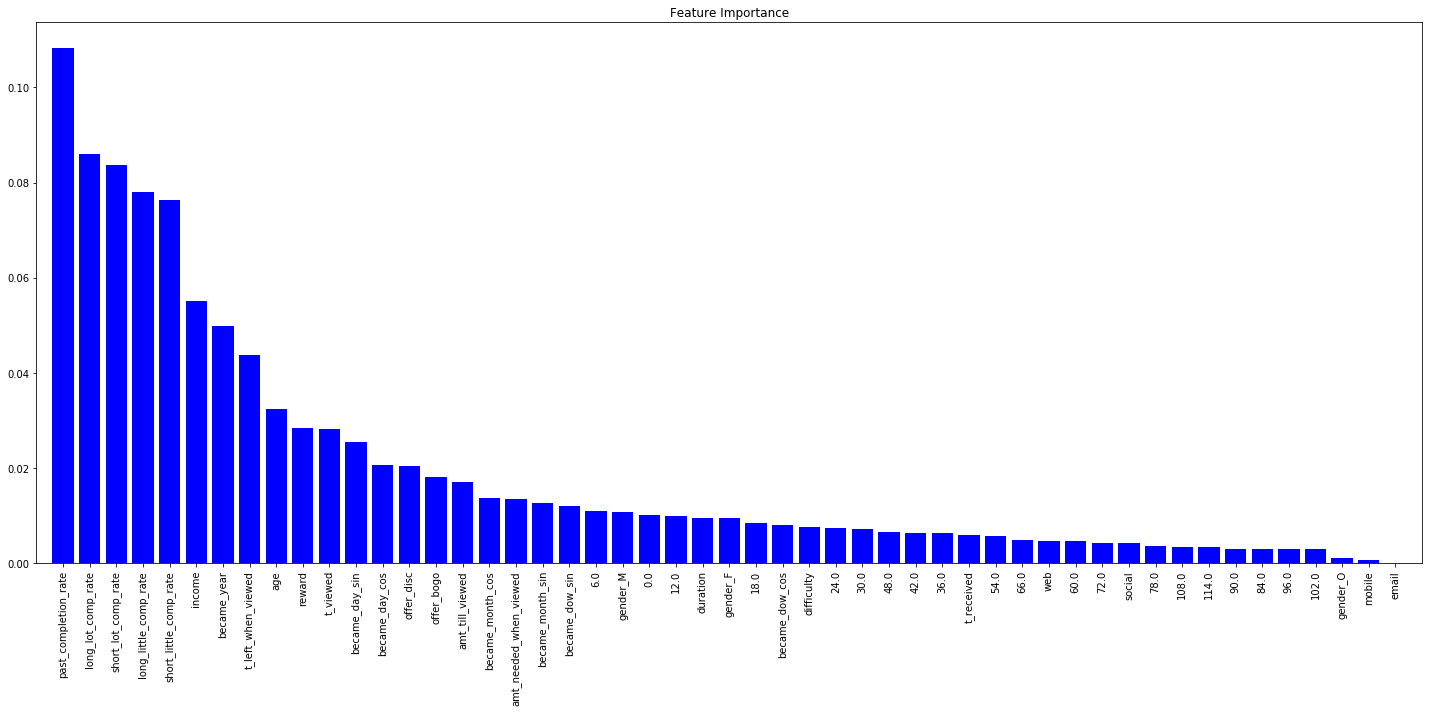

In [606]:
#特徴量の重要度
feature = gd1.best_estimator_.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),'feature': feature[:], 'f_name': indep_var2})
f2 = f.sort_values('feature',ascending=False)

#特徴量の名前
label = indep_var2[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.figure(figsize=(20,10))
plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='blue', align='center')
plt.xticks(range(len(feature)), f2.f_name, rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

### I will take a look at top 10 important features of this model.

```
1   past_completion_rate   0.18659521953364147
2   long_lot_comp_rate   0.08191259118268183
3   became_year   0.06747546281501476
4   income   0.06312119581440186
5   t_left_when_viewed   0.04825733767458709
6   long_little_comp_rate   0.037443030677931574
7   short_lot_comp_rate   0.0370296331200642
8   age   0.0339851178911399
9   t_viewed   0.029519463245205893
10  short_little_comp_rate   0.029358644621018382
```
```
1   past_completion_rate   0.10823659095118901
2   long_lot_comp_rate   0.08595954918332138
3   short_lot_comp_rate   0.08367514878558703
4   long_little_comp_rate   0.07800267360062899
5   short_little_comp_rate   0.07629602818899717
6   income   0.05515854732093211
7   became_year   0.04978646626207604
8   t_left_when_viewed   0.04372529933213142
9   age   0.032500881997055905
10   reward   0.028411643826730427
```

### [1]Features representing past completion rate of the customer

```
past_completion_rate(1)  
long_lot_comp_rate(2)  
short_lot_comp_rate(3) 
long_little_comp_rate(4)   
short_little_comp_rate(5)  
```

are about past completion rates and it makes sense that these are the most important features of all. Feature engineering in this notebook was worth doing!

### [2]Features representing attributes of the customer

```
became_year(6)  
income(7)  
age(9)  
```
are about attributes of the customer. It is concluded that the persons' attributes are more relevant to whether he would achieve the coupon rather than the coupon's type.

### [3]Features representing the coupon
```
t_left_when_viewed(8)  
reward(10)  
```
As was expected, remaining time and and the reward of a coupon have affect on customers' behavior. It is interesting that how much more amount of purchase the customer have to make to achieve the coupon is not important as these 2 factors. 